In [2]:
import torch
from torchvision import transforms
import json
from torchvision import models
import torch.nn as nn
import numpy as np
from PIL import Image

In [15]:
class AttributePredictor(nn.Module):
    def __init__(self, num_classes):
        super(AttributePredictor, self).__init__()
        self.resnet = models.resnet101(pretrained=False)  
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        logits = self.resnet(x)
        probs = self.sigmoid(logits)
        return probs

In [16]:
import torch

with open("/kaggle/input/attribute-prediction/vocab (1).json", "r") as f:
    vocab = json.load(f)
vocab_list = vocab
num_classes = len(vocab_list)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttributePredictor(num_classes=num_classes)


state_dict = torch.load("/kaggle/input/attribute-prediction/attribute_predictor_multi_gpu.pth", map_location=device)


if any(key.startswith("module.") for key in state_dict.keys()):
    state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}


model.load_state_dict(state_dict, strict=False)  
model.to(device)
model.eval()

<ipython-input-16-cf58a6586931>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/attribute-prediction/attribute_predictor_multi_gpu.p

AttributePredictor(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


Predicted Attributes: ['tennis', 'on', 'player', 'court', 'racket']


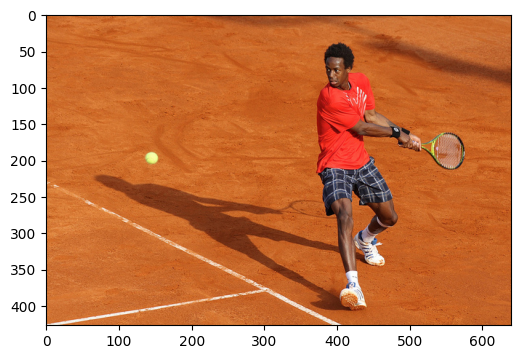

In [24]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


image_path = "/kaggle/input/attribute-prediction/000000000057.jpg" 
image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(6, 6))
plt.imshow(image)

image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    predictions = model(image_tensor).squeeze(0).cpu()

top_indices = torch.topk(predictions, k=5).indices
predicted_attributes = [vocab_list[idx] for idx in top_indices]

print("Predicted Attributes:", predicted_attributes)
